In [19]:
# allow to import modules from the project root directory
import sys
import os
# Add the project root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from src.ParObsSnakeEnv import ParObsSnakeEnv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.utils import compute_metrics

In [ ]:
# Simple Actor-Critic implementation
# Version №1
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.Dropout(x)
        logits = self.fc2(x)
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

In [ ]:
# Updated Actor-Critic implementation (more complex)
# Version №2
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.num_actions = num_actions
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.Dropout(x)
        logits = self.fc4(x)
        return logits
    
    def choose_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = self.forward(state_tensor)
        action_probs = F.softmax(logits, dim=1)
        action = np.random.choice(self.num_actions, p=action_probs.detach().numpy()[0])
        return action, action_probs

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        value = self.fc4(x)
        return value

In [22]:
env = ParObsSnakeEnv(grid_size=10, interact=False)
num_actions = env.action_space.n
num_inputs = env.observation_space.shape[0]

In [23]:
gamma = 0.99
actor_lr = 0.0001
critic_lr = 0.0001
num_episodes = 5000

In [24]:
actor = Actor(num_inputs, num_actions)
critic = Critic(num_inputs)
criterion = nn.MSELoss()
episode_reward_list = list()

In [26]:
# Initialize optimizers and learning rate schedulers
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

In [27]:
# Initialize lists to store statistics
actor_losses = []
critic_losses = []
episode_rewards = []

# Training loop
for episode in tqdm(range(num_episodes), desc="Training Episodes"):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action, action_probs = actor.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

        if done:
            reward = -1

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        value = critic(state_tensor)
        next_value = critic(next_state_tensor)

        target_value = reward + gamma * next_value * (1 - int(done))
        advantage = target_value - value

        actor_loss = -torch.log(action_probs[0, action]) * advantage.item()
        critic_loss = criterion(value, target_value.detach())

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        actor_optimizer.step()
        critic_optimizer.step()

        state = next_state

    # Store statistics
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())
    episode_rewards.append(episode_reward)

Training Episodes: 100%|██████████| 5000/5000 [16:10<00:00,  5.15it/s]


In [29]:
# save the models 
torch.save(actor.state_dict(), "../../models/actor_v2.pth")
torch.save(critic.state_dict(), "../../models/critic_v2.pth")

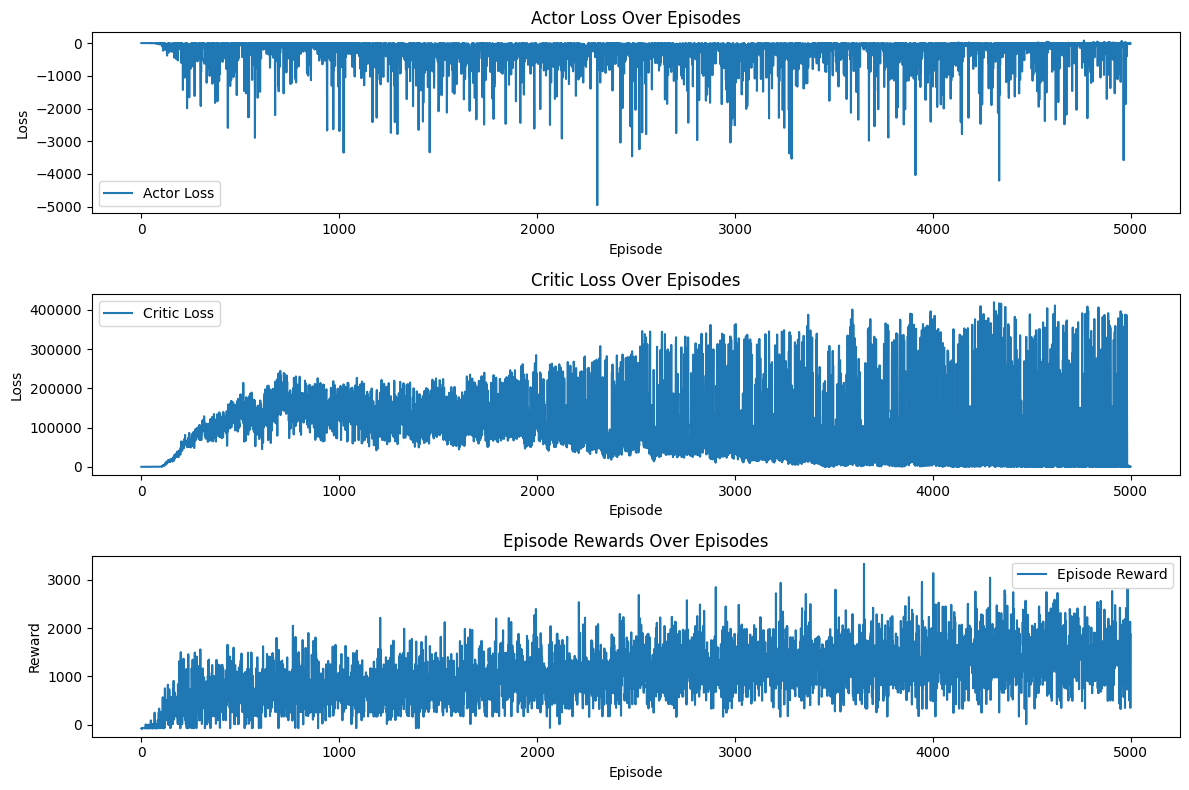

In [30]:
# Plotting the statistics
plt.figure(figsize=(12, 8))

# Plot actor losses
plt.subplot(3, 1, 1)
plt.plot(actor_losses, label='Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Actor Loss Over Episodes')
plt.legend()

# Plot critic losses
plt.subplot(3, 1, 2)
plt.plot(critic_losses, label='Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Critic Loss Over Episodes')
plt.legend()

# Plot episode rewards
plt.subplot(3, 1, 3)
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards Over Episodes')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
actor = Actor(num_inputs, num_actions)
actor.load_state_dict(torch.load("../../models/actor.pth"))

<All keys matched successfully>

In [31]:
env = ParObsSnakeEnv(grid_size=20, interact=True)

2024-11-28 20:40:10.433 python[7421:51396] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-28 20:40:10.433 python[7421:51396] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [32]:
stats = compute_metrics(actor, env, num_simulations = 10)

 10%|█         | 1/10 [00:55<08:18, 55.33s/it]

Snake length: 35, Episode reward: 2982


 20%|██        | 2/10 [01:49<07:17, 54.74s/it]

Snake length: 34, Episode reward: 2844


 30%|███       | 3/10 [03:08<07:39, 65.61s/it]

Snake length: 54, Episode reward: 4631


 40%|████      | 4/10 [03:32<04:56, 49.45s/it]

Snake length: 19, Episode reward: 1517


 50%|█████     | 5/10 [04:42<04:44, 56.82s/it]

Snake length: 47, Episode reward: 3960


 60%|██████    | 6/10 [04:58<02:52, 43.01s/it]

Snake length: 16, Episode reward: 1190


 70%|███████   | 7/10 [05:35<02:02, 40.77s/it]

Snake length: 28, Episode reward: 2282


 80%|████████  | 8/10 [06:03<01:13, 36.92s/it]

Snake length: 19, Episode reward: 1535


 90%|█████████ | 9/10 [07:28<00:51, 51.86s/it]

Snake length: 52, Episode reward: 4500


100%|██████████| 10/10 [07:57<00:00, 47.72s/it]

Snake length: 22, Episode reward: 1758


In [33]:
snake_lengths = stats['snake_lengths']
episode_rewards = stats['episode_rewards']

Average Snake Length: 32.6
Average Episode Reward: 2719.9


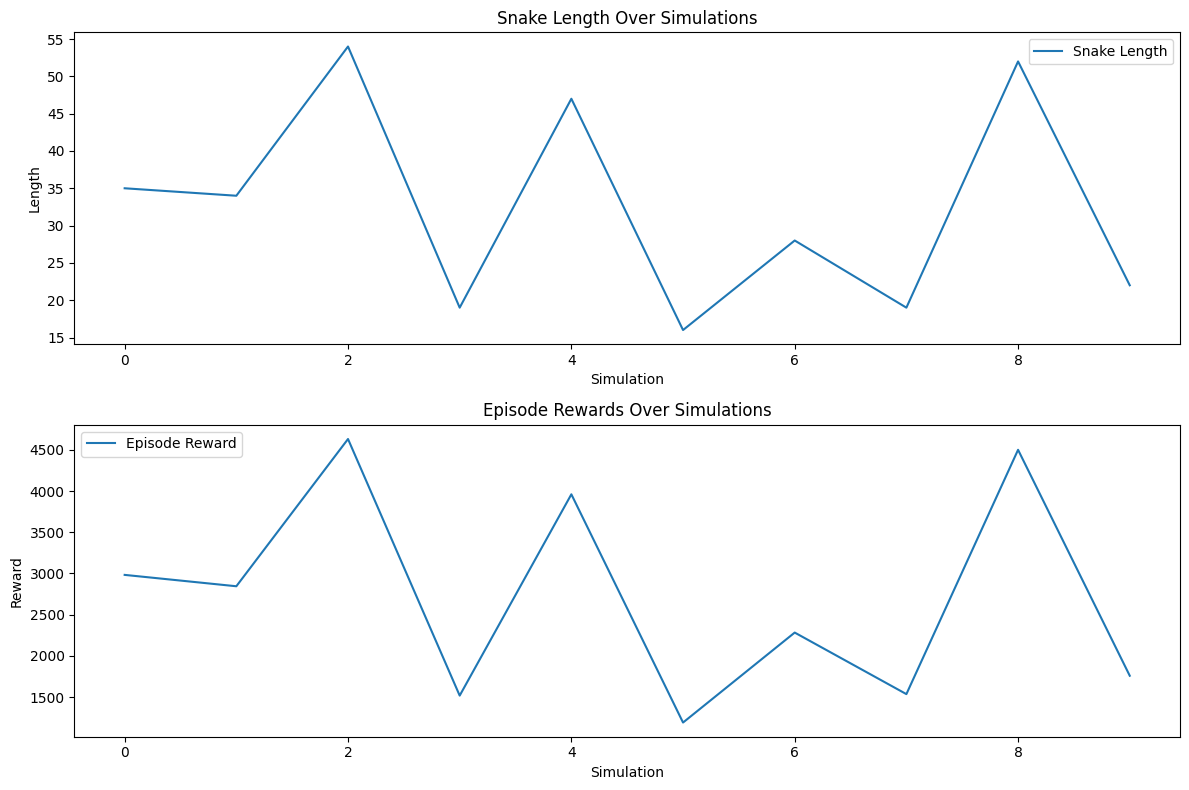

In [34]:
# Print metrics
print("Average Snake Length:", np.mean(snake_lengths))
print("Average Episode Reward:", np.mean(episode_rewards))

# Plotting the metrics
plt.figure(figsize=(12, 8))

# Plot snake lengths
plt.subplot(2, 1, 1)
plt.plot(snake_lengths, label='Snake Length')
plt.xlabel('Simulation')
plt.ylabel('Length')
plt.title('Snake Length Over Simulations')
plt.legend()

# Plot episode rewards
plt.subplot(2, 1, 2)
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Simulation')
plt.ylabel('Reward')
plt.title('Episode Rewards Over Simulations')
plt.legend()

plt.tight_layout()
plt.show()